## Q3. Named Entity Recognition
we will start by loading the spanish and dutch dataset.

In [ ]:
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import matplotlib.pyplot as plt

## Q3.1 Features

first we obtain the cnoll2002 dataset in Spanish and Dutch using the following line

In [3]:
nltk.download('conll2002')

from nltk.corpus import conll2002

etr = conll2002.iob_sents('esp.train') # In Spanish
eta = conll2002.iob_sents('esp.testa') # In Spanish
etb = conll2002.iob_sents('esp.testb') # In Spanish

dtr = conll2002.iob_sents('ned.train') # In Dutch
dta = conll2002.iob_sents('ned.testa') # In Dutch
dtb = conll2002.iob_sents('ned.testb') # In Dutch

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


we wiil now explore the dataset , we will check how many tags are there in the train sets , how many pos-tags are there in the dataset(just to get some statistics before we start our task).

Text(0, 0.5, 'frequency')

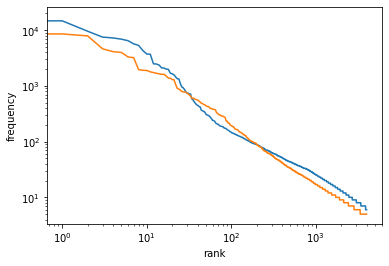

In [4]:
from collections import Counter

words_counter_spanish = Counter([word[0] for sentence in etr for word in sentence])
words_counter_dutch = Counter([word[0] for sentence in dtr for word in sentence])

plt.loglog([val for word,val in words_counter_spanish.most_common(4000)])
plt.xlabel('rank')
plt.ylabel('frequency')

plt.loglog([val for word,val in words_counter_dutch.most_common(4000)])
plt.xlabel('rank')
plt.ylabel('frequency')

from the chart below we can see that the most common words follow Zip's law. we will now explore the number of diffrent labels in the data set.

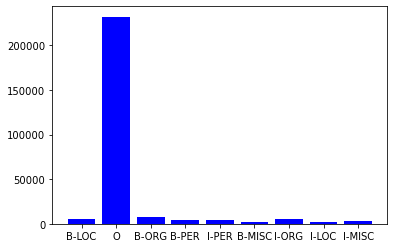

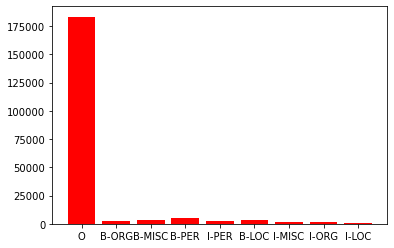

In [5]:
label_counter_spanish = Counter([word[2] for sentence in etr for word in sentence])
label_counter_dutch = Counter([word[2] for sentence in dtr for word in sentence])

plt.bar(label_counter_spanish.keys(), label_counter_spanish.values(), color='blue')
plt.show()
plt.bar(label_counter_dutch.keys(), label_counter_dutch.values(), color='red')
plt.show()

we can see from the histogram that the label 'O' is by far the most common label in the data set and all the other label are quite equal. we will now explore the number of diffrent pos-tags in the dataset.

59


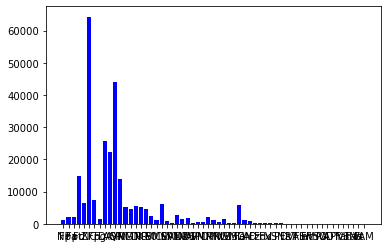

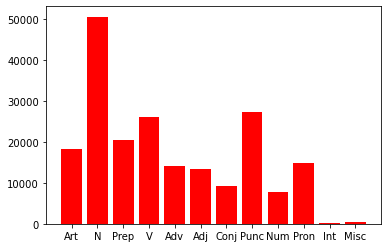

In [6]:
pos_tag_counter_spanish = Counter([word[1] for sentence in etr for word in sentence])
pos_tag_counter_dutch = Counter([word[1] for sentence in dtr for word in sentence])

print(len(pos_tag_counter_spanish.keys()))

plt.bar(pos_tag_counter_spanish.keys(), pos_tag_counter_spanish.values(), color='blue')
plt.show()
plt.bar(pos_tag_counter_dutch.keys(), pos_tag_counter_dutch.values(), color='red')
plt.show()

that is actually intresting, there are 59 diffrent pos-tags in spanish langague(we didn't know that) which could maybe make the problem easier for the classifier. we will plot the most_common(20) agian to see their values.

<BarContainer object of 20 artists>

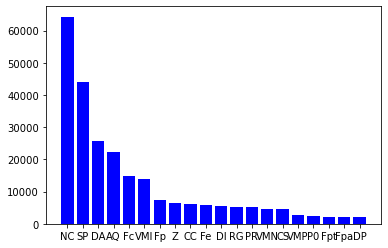

In [7]:
most_common = pos_tag_counter_spanish.most_common(20)
plt.bar([x[0] for x in most_common] , [x[1] for x in most_common], color='blue')

## Q3.1.1 Feature Extraction:

we will start by trying diffrent features and see which one gives us the best results on the evaluation dataset , we will check the recall and the precision since we can cleary see that this data set is not balanced.

In [8]:
import string

def calculateORT(word):
    if '.com' in word or 'http' in word:
        return 'url'
    if word.isdigit():
        return 'number'
    elif any(char.isdigit() for char in word):
        return 'contain-number'
    if '-' in word:
        return 'contains-hyphen'
    if word.isupper():
        return 'all-capitals'
    elif any(char.isupper() for char in word):
        return 'capitalized'
    if any(char in string.punctuation for char in word):
        return 'punctuation'
    return 'regular'
    

def word2features(words, i, key_features):
    word = words[i][0]
    postag = words[i][1]
    prev_pos_tag = 'BOS'
    next_pos_tag = 'EOS'
    if i > 0:
        prev_pos_tag = words[i-1][1]
    if i < len(words) - 1:
        next_pos_tag = words[i+1][1]
    features = {
         'word': word,
         'prev-pos-tag': prev_pos_tag,
         'next-pos-tag': next_pos_tag,
         'pos-tag': postag,
         'ORT': calculateORT(word),
         'prefix1': word[:1],
         'prefix2': word[:2],
         'prefix3': word[:3],
         'suffix1': word[-1:],
         'suffix2': word[-2:],
         'suffix3': word[-3:]
    }
    
    return {key: value for key,value in features.items() if key in key_features}

def sentences2features(sentences, function):
    features = []
    for sentence in sentences:
        features.extend(function(sentence))
    return features

def sentence2features(sentence, features):
    return [word2features(sentence,i, features) for i in range(len(sentence))]

def sentence2labels(words):
    return [label for token, postag, label in words]

def calculate_features(dataset, features):
    return sentences2features(dataset, lambda x : sentence2features(x,features_keys)), sentences2features(dataset, sentence2labels)

so we have written the function to calculate the featues , we will now try diffrent combinations and evaluate and we will pick the best one. we will first use the spanish dataset and afterwards the dutch one.

In [9]:
features_keys = ['word', 'pos-tag', 'ORT']

x_train, y_train = calculate_features(etr, features_keys)

x_eval, y_eval = calculate_features(eta, features_keys)

we will now use the DictVectorizer class provided by sklearn , the class converts a dict with string values into a vector with dimension k which is calculated during that process.
let's see how many dimensions we get when we use it on our dataset , if the vector has to many dimensions then the classifier will preform poorly, he will not be able to generalize well.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report


def get_vector_size(data):
    v = DictVectorizer(sparse=False)
    new_x_train = v.fit_transform(x_train)
    return len(v.get_feature_names())

print(get_vector_size(x_train))

26166


we can see that the size of the vector is very large(k=26165) which in my opinion is the vocabulary size, so we can allready see that using the word as a feature wont result in a good results.

## Q3.1.2 Model Training

lets try to fit those features to the model.

In [11]:
def train_model(x_train, y_train):
    pipe = make_pipeline(DictVectorizer(), LogisticRegression(max_iter=300))
    pipe.fit(x_train, y_train)
    return pipe

def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return classification_report(y_pred, y_test)

model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

C:\Users\Dani\miniconda3\envs\nlp22\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       B-LOC       0.83      0.39      0.53      2069
      B-MISC       0.39      0.63      0.48       275
       B-ORG       0.68      0.76      0.72      1528
       B-PER       0.55      0.71      0.62       946
       I-LOC       0.33      0.69      0.45       161
      I-MISC       0.13      0.61      0.22       141
       I-ORG       0.23      0.68      0.34       466
       I-PER       0.58      0.48      0.53      1025
           O       0.99      0.97      0.98     46312

    accuracy                           0.92     52923
   macro avg       0.52      0.66      0.54     52923
weighted avg       0.95      0.92      0.93     52923



the accuracy of the model is 92% but we can see that he is very good at 'O' label since is the most common one in the dataset , but it preforms poorly on the other labels.
lets try a diffrent set of featurs, we will remove the 'word' feature and add the suffix prefix to get lower dimension data.

In [12]:
features_keys = ['pos-tag', 'ORT', 'suffix1', 'prefix1']

x_train, y_train = calculate_features(etr, features_keys)

x_eval, y_eval = calculate_features(eta, features_keys)

In [13]:
print(get_vector_size(x_train))

236


we can observe that the vector size is significantly(k=236) , but maybe it is to small for the problem and the model wont be able to converge at all. we might need some better features, lets try to fit the model

In [14]:
model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

C:\Users\Dani\miniconda3\envs\nlp22\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       B-LOC       0.37      0.26      0.31      1384
      B-MISC       0.11      0.35      0.16       133
       B-ORG       0.62      0.43      0.50      2460
       B-PER       0.36      0.44      0.39      1013
       I-LOC       0.09      0.70      0.16        44
      I-MISC       0.02      0.26      0.03        38
       I-ORG       0.14      0.29      0.19       653
       I-PER       0.38      0.35      0.36       946
           O       0.99      0.97      0.98     46252

    accuracy                           0.90     52923
   macro avg       0.34      0.45      0.34     52923
weighted avg       0.92      0.90      0.91     52923



we can cleary see that our model is very bad, he can only predict the label 'O' and somtimes some other labels but in general it doesnt preform well at all, lets try diffrent set of features.

In [15]:
features_keys = ['pos-tag', 'ORT', 'suffix3', 'prefix3']

x_train, y_train = calculate_features(etr, features_keys)

x_eval, y_eval = calculate_features(eta, features_keys)

In [16]:
print(get_vector_size(x_train))

9836


we can see that our vector is much bigger now , lets hope that it does better job then before.

In [17]:
model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

C:\Users\Dani\miniconda3\envs\nlp22\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       B-LOC       0.76      0.53      0.62      1428
      B-MISC       0.39      0.53      0.45       328
       B-ORG       0.71      0.70      0.70      1730
       B-PER       0.60      0.62      0.61      1184
       I-LOC       0.30      0.56      0.39       178
      I-MISC       0.13      0.39      0.19       216
       I-ORG       0.25      0.56      0.34       600
       I-PER       0.51      0.50      0.50       890
           O       1.00      0.97      0.98     46369

    accuracy                           0.93     52923
   macro avg       0.52      0.59      0.53     52923
weighted avg       0.94      0.93      0.93     52923



this model looks alot better and it reached 93% but if we will take a look at the macro avg compared(we will see that it preforms just like our first model) , so in general the best features are  ['pos-tag', 'ORT', 'suffix3', 'prefix3'] and since we are picking a word we might encouter some unseen words in the test set which could result in bad performence, so this is the best set of features. we will also try to add the previos word pos-tag and the next word pos tag to the second set of features to see if we get some imporvment.

In [18]:
features_keys = ['pos-tag', 'prev-pos-tag', 'next-pos-tag' 'ORT', 'suffix3', 'prefix3']

x_train, y_train = calculate_features(etr, features_keys)

x_eval, y_eval = calculate_features(eta, features_keys)

In [19]:
model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

C:\Users\Dani\miniconda3\envs\nlp22\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       B-LOC       0.71      0.57      0.63      1211
      B-MISC       0.39      0.56      0.46       309
       B-ORG       0.65      0.73      0.69      1525
       B-PER       0.63      0.81      0.71       945
       I-LOC       0.32      0.60      0.42       181
      I-MISC       0.15      0.45      0.22       218
       I-ORG       0.26      0.56      0.36       629
       I-PER       0.65      0.60      0.62       933
           O       1.00      0.96      0.98     46972

    accuracy                           0.93     52923
   macro avg       0.53      0.65      0.57     52923
weighted avg       0.95      0.93      0.94     52923



we can see that this model preform better in all the ones the other one failed to (I-MISC, I-ORG, I-LOC) and it has the same accuracy of 93% but with macro avg alitle bit better, we will use that model to our final evaluation.

In [20]:
features_keys = ['pos-tag', 'prev-pos-tag', 'next-pos-tag' 'ORT', 'suffix3', 'prefix3']

x_train, y_train = calculate_features(etr, features_keys)
x_test, y_test = calculate_features(etb, features_keys)

model = train_model(x_train, y_train)
print(evaluate_model(model, x_test, y_test))

C:\Users\Dani\miniconda3\envs\nlp22\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       B-LOC       0.66      0.67      0.67      1060
      B-MISC       0.34      0.50      0.40       229
       B-ORG       0.79      0.76      0.77      1465
       B-PER       0.67      0.75      0.71       651
       I-LOC       0.20      0.57      0.30       114
      I-MISC       0.13      0.46      0.20       155
       I-ORG       0.27      0.54      0.36       538
       I-PER       0.73      0.66      0.69       693
           O       1.00      0.97      0.98     46628

    accuracy                           0.94     51533
   macro avg       0.53      0.66      0.56     51533
weighted avg       0.96      0.94      0.95     51533



it has some pit falls like I-MISC, I-ORG, I-LOC but in general this model is pretty good. lets take a look at the confusion matrix.

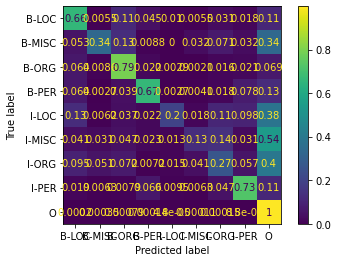

In [21]:
plot_confusion_matrix(model, x_test, y_test, normalize='true')

we can see that the diagonal has the biggest values except the ones we observed before(I-MISC, I-ORG, I-LOC, B-MISC) which the model doesn't preform well on them, since 'O' is by far the most common label in the dataset, we can see that the precision in the label is 1.

## Q3.1.3 Greedy Tagging vs. Sequence Tagging

now we will try to calculate the wrong sequences in the predicted sentences , in the form of (O-IX, IX-IY, BX-IY)

In [22]:
def wrong_sequences(labeled_sequence):
    wrong_sequences_list = []
    counter = 0
    for i in range(len(labeled_sequence) - 1):
        splitted_label_i = labeled_sequence[i].split('-')
        splitted_label_next_i = labeled_sequence[i+1].split('-')
        if labeled_sequence[i] == 'O' and 'I' == splitted_label_i[0]:
            counter += 1
        elif 'I' == splitted_label_i[0] and 'I' == splitted_label_next_i[0] and labeled_sequence[i] != labeled_sequence[i+1]:
            counter += 1
        elif 'B' == splitted_label_i[0] and 'I' == splitted_label_next_i[0] and splitted_label_i[1] != splitted_label_next_i[1]:
            counter += 1
    return counter

In [23]:
predictions = model.predict(x_eval)
print('we have {x} wrong sequence in the evaluation dataset of size {y}'.format(x=wrong_sequences(predictions), y=len(x_eval)))

predictions = model.predict(x_test)
print('we have {x} wrong sequence in the test dataset of size {y}'.format(x=wrong_sequences(predictions), y=len(x_test)))

we have 371 wrong sequence in the evaluation dataset of size 52923
we have 286 wrong sequence in the test dataset of size 51533


our evaluation dataset and test dataset has over 50k labaled examples , we have structure problem in only 371,286 respectivaly which is less then 1%. it look's like our model perform well. we will repeat the same process with the dutch dataset.

In [24]:
features_keys = ['word', 'pos-tag', 'ORT']

x_train, y_train = calculate_features(dtr, features_keys)

x_eval, y_eval = calculate_features(dta, features_keys)

In [25]:
print(get_vector_size(x_train))

27823


we can see like in spanish the using the 'word' as a feature create a very high dimensional vector, in general we would like to reduce that size like i explained erlier, lets try to train our model.

In [26]:
model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

C:\Users\Dani\miniconda3\envs\nlp22\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       B-LOC       0.49      0.84      0.62       279
      B-MISC       0.41      0.89      0.57       347
       B-ORG       0.41      0.79      0.54       355
       B-PER       0.90      0.34      0.49      1861
       I-LOC       0.17      0.85      0.29        13
      I-MISC       0.20      0.58      0.29        72
       I-ORG       0.32      0.77      0.45       164
       I-PER       0.23      0.65      0.34       148
           O       1.00      0.98      0.99     34448

    accuracy                           0.94     37687
   macro avg       0.46      0.74      0.51     37687
weighted avg       0.97      0.94      0.95     37687



we will now try to use a diffrent set of features , we will remove the word feature and we will use suffix and prefix like we tryed in the spanish dataset.

In [27]:
features_keys = ['prefix1', 'suffix1', 'pos-tag', 'ORT']

x_train, y_train = calculate_features(dtr, features_keys)

x_eval, y_eval = calculate_features(dta, features_keys)
print(get_vector_size(x_train))

189


we can see like in the spanish dataset , that the vector size here is very small , which can indicate that there isn't enought data to train the model, lets try to train it and see the results.

In [ ]:
model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

we can see that that model doesn't preform well as the first one, we can observe a very low accuracy at I-LOC, I-MISC classes which can be a good indection of a overfit('O' label as 99%). lets try a diffrent set of features.

In [ ]:
features_keys = ['prefix3', 'suffix3', 'pos-tag', 'ORT']

x_train, y_train = calculate_features(dtr, features_keys)

x_eval, y_eval = calculate_features(dta, features_keys)
print(get_vector_size(x_train))

now the vector size looks alot better , its not to big and not to small, we will now train the model.

In [ ]:
model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

we can allready see that this model perform better then the first one, lets add the next and prev pos tag features the our features and observe the results.

In [ ]:
features_keys = ['pos-tag', 'prev-pos-tag', 'next-pos-tag' 'ORT', 'suffix3', 'prefix3']

x_train, y_train = calculate_features(dtr, features_keys)

x_eval, y_eval = calculate_features(dta, features_keys)
print(get_vector_size(x_train))

model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

we get allite increase in dimensions when we add those features but still we can see that this model preform alots better in the small classes like I-MISC and I-LOC, I-PER but it has some problems in other classes unlike the prevois model(B-MISC, B-ORG), we will choose that model as our final model since the macro avg is bigger. we will now evaluate it aginst the test data set.

In [ ]:
x_test, y_test = calculate_features(dtb, features_keys)

print(evaluate_model(model, x_test, y_test))

we can ovserve that the model is generaly good , but it still has some pit falls because the dataset is not balanced , but it reflects the real word. this model perform poorly on classes like I-MISC, I-LOC, B-ORG, I-ORG but in the others it performs well.

In [ ]:
plot_confusion_matrix(model, x_test, y_test, normalize='true')

just like in the spanish dataset , we can see from the confusion matrix that the data set in higly imblanced, but the values on the diagonal are the biggest in most classes.

## Q3.2 Using Word Embeddings

we will now try to add word embedding vectors as features to our spanish model and evaluate the results. we will use our latest model as the starting point.

In [34]:
from gensim.models import KeyedVectors

vec = KeyedVectors.load_word2vec_format('../data/wiki.es.vec')

we loaded the word2vec file using KeyedVector class and we will now change our feature extraction function to use those vectors, since we dont need to change features any more we will change our function to use static features. note that some of the word might not be found on the word2vec and we will use default vector which is all zeros with size 300 because that is the size of the vectors , also in the begining and the end of the sentence we will use the same vector as padding to the words.

In [39]:
import numpy as np

default_vector = np.zeros(300)

def get_vector(word):
    return vec.get_vector(word) if word in vec else default_vector

def convert_vector_to_dict(word_vec, prefix):
    return {prefix + str(i): word_vec[i] for i in range(len(word_vec))}

def word2features(words, i):
    word = words[i][0]
    postag = words[i][1]
    prev_pos_tag = 'BOS'
    next_pos_tag = 'EOS'
    prev_word_vec = default_vector
    next_word_vec = default_vector
    word_vec = get_vector(word)
    if i > 0:
        prev_word_vec = get_vector(words[i-1][0])
        prev_pos_tag = words[i-1][1]
    if i < len(words) - 1:
        next_pos_tag = words[i+1][1]
        next_word_vec = get_vector(words[i+1][0])
    features = {
         'prev-pos-tag': prev_pos_tag,
         'next-pos-tag': next_pos_tag,
         'pos-tag': postag,
         'ORT': calculateORT(word),
         'prefix3': word[:3],
         'suffix3': word[-3:],
    }
    
    
    features.update(convert_vector_to_dict(word_vec, 'word-vec'))
    features.update(convert_vector_to_dict(prev_word_vec, 'prev-word-vec'))
    features.update(convert_vector_to_dict(next_word_vec, 'next-word-vec'))
    return features

def sentences2features(sentences, function):
    features = []
    for sentence in sentences:
        features.extend(function(sentence))
    return features

def sentence2features(sentence):
    return [word2features(sentence,i) for i in range(len(sentence))]

def sentence2labels(words):
    return [label for token, postag, label in words]

def calculate_features(dataset):
    return sentences2features(dataset, sentence2features), sentences2features(dataset, sentence2labels)

we will now load our dataset with the new features.

In [40]:
x_train, y_train = calculate_features(etr)
x_eval, y_eval = calculate_features(eta)

print(get_vector_size(x_train))

10854


we can see that our vector size is bigger in 900 dimensions since we are adding 3 vectors each with size 300, lets try to train the model and see if we got some better results.

In [41]:
model = train_model(x_train, y_train)
print(evaluate_model(model, x_eval, y_eval))

C:\Users\Dani\miniconda3\envs\nlp22\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       B-LOC       0.74      0.57      0.64      1261
      B-MISC       0.44      0.53      0.48       366
       B-ORG       0.75      0.77      0.76      1670
       B-PER       0.77      0.88      0.82      1069
       I-LOC       0.40      0.57      0.47       239
      I-MISC       0.19      0.40      0.25       311
       I-ORG       0.53      0.60      0.56      1219
       I-PER       0.81      0.70      0.75       983
           O       0.99      0.98      0.99     45805

    accuracy                           0.94     52923
   macro avg       0.62      0.67      0.64     52923
weighted avg       0.95      0.94      0.95     52923



we can see that this model macro avg is alot better then the last ones , but it took alot of training time , lets test it aginst our test set.

In [42]:
x_test, y_test = calculate_features(etb)

print(evaluate_model(model, x_test, y_test))

              precision    recall  f1-score   support

       B-LOC       0.70      0.71      0.71      1063
      B-MISC       0.41      0.51      0.45       273
       B-ORG       0.83      0.76      0.79      1543
       B-PER       0.85      0.83      0.84       749
       I-LOC       0.28      0.63      0.39       146
      I-MISC       0.17      0.40      0.24       235
       I-ORG       0.58      0.59      0.58      1086
       I-PER       0.87      0.74      0.80       746
           O       1.00      0.99      0.99     45692

    accuracy                           0.96     51533
   macro avg       0.63      0.68      0.64     51533
weighted avg       0.96      0.96      0.96     51533



it also has better accuracy and macro avg at the test set and those features are probably the best choise of features for that problem.

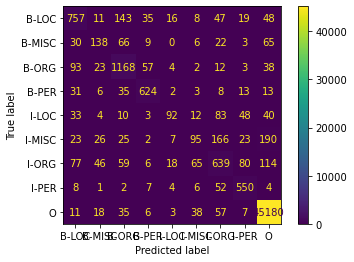

In [43]:
plot_confusion_matrix(model, x_test, y_test, normalize='true')

the confusion matrix is almost the ssame but it looks like the diagonal values are bigger then before , we can also see that from the evaluate report.